# EECE5644 Assignment 4 - Question 1

## Description:

This notebook implements and compares two classification algorithms (Support Vector Machines (SVM) and Multi-Layer Perceptrons (MLP)) on synthetic 2D datasets. The project includes hyperparameter tuning via cross-validation, decision boundary visualization, and performance analysis.

## Table of Contents:
1. Imports & Setup
2. Data Generation
3. SVM
4. MLP
5. Analysis & Comparison

## 1. Setup & Imports

### Description:

This section imports all necessary libraries for the assignment and sets random seeds for reproducibility.

### Table of Contents:
- 1.1 Imports
- 1.2 Random Seed

In [1]:
# @title 1.1 Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from typing import Tuple, List, Dict, Optional
from matplotlib.axes import Axes
from matplotlib.figure import Figure

import warnings
warnings.filterwarnings('ignore')

In [2]:
# @title 1.2 Random Seed
np.random.seed(42)

## 2. Data Generation

### Description:

This section generates training and testing data for two concentric disk classes:
 - Class -1: radius r = 2
 - Class +1: radius r = 4
 - Noise: Gaussian with σ = 1


### Table of Contents:
- 2.1 Generate Data Function
- 2.2 Generate Training & Test Data
- 2.3 Visualize Data

In [3]:
# @title 2.1 Generate Data Function
def generate_data(
    n_samples: int,
    r_minus: float,
    r_plus: float,
    sigma: float
  ) -> Tuple[np.ndarray, np.ndarray]:
  """
  Generate training/testing data for two concentric disk classes.
  """
  X = []
  y = []

  for label in [-1, 1]:
    r = r_minus if label == -1 else r_plus

    for _ in range(n_samples // 2):
      theta = np.random.uniform(-np.pi, np.pi)
      noise = np.random.multivariate_normal([0, 0], sigma**2 * np.eye(2))
      x = r * np.array([np.cos(theta), np.sin(theta)]) + noise
      X.append(x)
      y.append(label)

  return np.array(X), np.array(y)


In [4]:
# @title 2.2 Generate Training & Test Data

# parameters
r_minus = 2.0
r_plus = 4.0
sigma = 1.0
n_train = 1000
n_test = 10000

# generate datasets
X_train, y_train = generate_data(n_train, r_minus, r_plus, sigma)
X_test, y_test = generate_data(n_test, r_minus, r_plus, sigma)

# print stats
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

print(f"\nClass distribution (train): {np.sum(y_train == -1)} class -1, {np.sum(y_train == 1)} class +1")
print(f"Class distribution (test): {np.sum(y_test == -1)} class -1, {np.sum(y_test == 1)} class +1")

print(f"\nTraining sample: X = {X_train[0]}, y = {y_train[0]}")

Training samples: 1000
Test samples: 10000

Class distribution (train): 500 class -1, 500 class +1
Class distribution (test): 5000 class -1, 5000 class +1

Training sample: X = [ 0.29824115 -1.09939186], y = -1


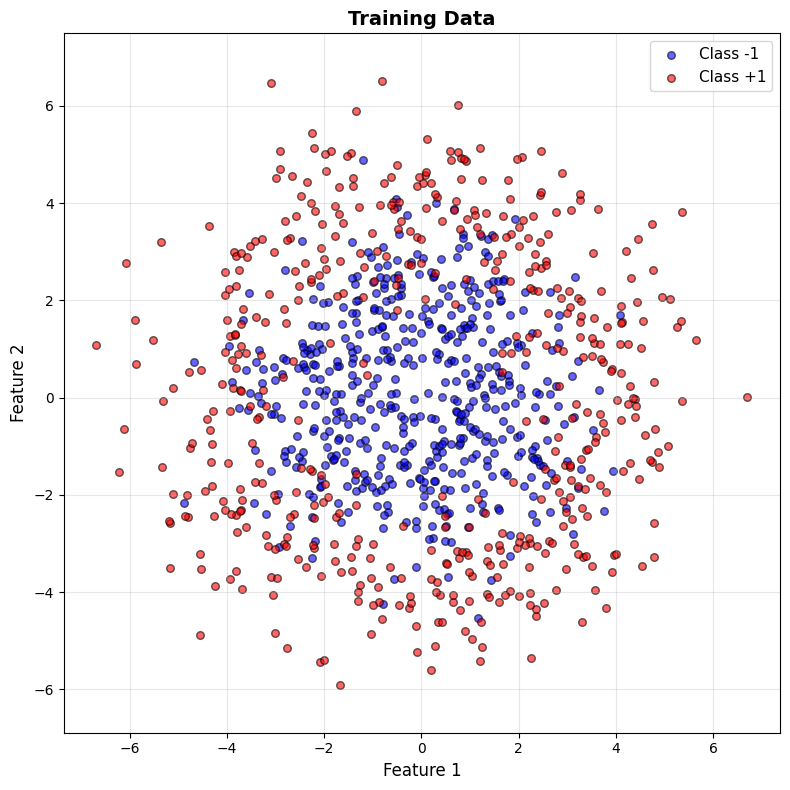

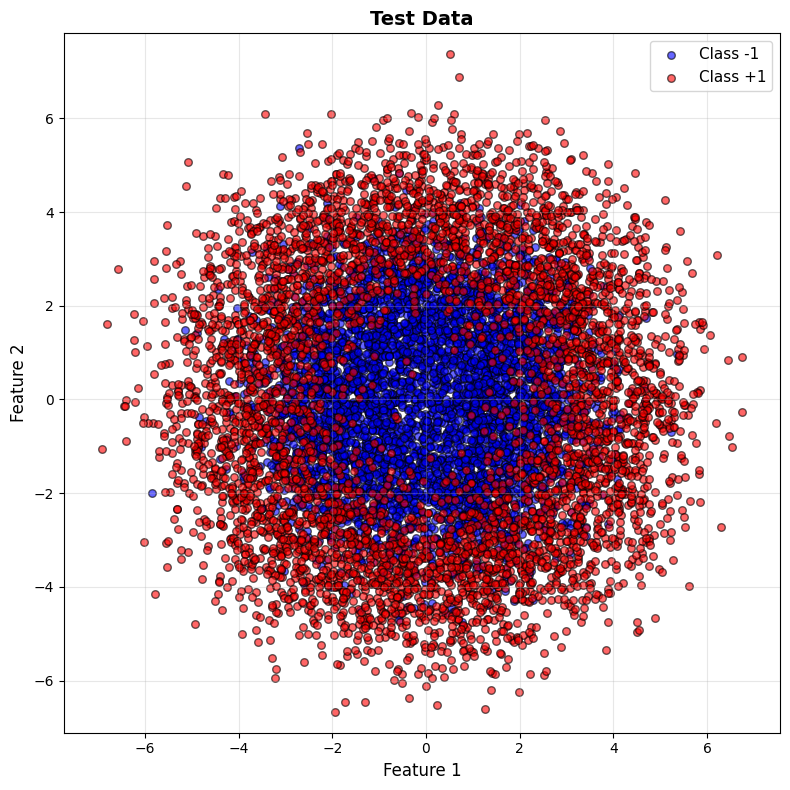

In [5]:
# @title 2.3 Visualize Data

# training data
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], c='blue', label='Class -1', alpha=0.6, edgecolors='k', s=30)
ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='red', label='Class +1', alpha=0.6, edgecolors='k', s=30)
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.set_title('Training Data', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.tight_layout()
plt.show()

# test data
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], c='blue', label='Class -1', alpha=0.6, edgecolors='k', s=30)
ax.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], c='red', label='Class +1', alpha=0.6, edgecolors='k', s=30)
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.set_title('Test Data', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.tight_layout()
plt.show()

## 3. SVM

### Description:

This section implements a SVM classifier with RBF kernel. It performs hyperparameter tuning using K-fold cross-validation to find optimal values for C (regularization parameter) and gamma (kernel coefficient). The best model is then trained on the full training set and evaluated on test data.

### Table of Contents:
- 3.1 SVM Cross-Validation Function
- 3.2 Perform SVM Cross-Validation
- 3.3 Visualize SVM Cross-Validation Results
- 3.4 Train Final SVM Model
- 3.5 Analyze Final SVM Model

In [6]:
# @title 3.1 SVM Cross-Validation Function
def svm_cross_validation(
    X_train: np.ndarray,
    y_train: np.ndarray,
    k_folds: int = 10
  ) -> Tuple[Dict[str, float], List[Dict[str, float]]]:
  """
  Perform K-fold cross-validation for SVM hyperparameter selection.
  """
  # hyperparameter space
  gamma_values = np.logspace(-3, 2, 20)
  C_values = np.logspace(-2, 3, 20)

  # initialize
  kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
  best_score = 0.0
  best_params: Dict[str, float] = {}
  results: List[Dict[str, float]] = []

  print("SVM Cross-Validation Progress:")
  for i, gamma in enumerate(gamma_values):
    for j, C in enumerate(C_values):
      scores = []
      for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # train & evaluate svm with current parameters
        model = SVC(kernel='rbf', gamma=gamma, C=C, random_state=42)
        model.fit(X_tr, y_tr)
        score = accuracy_score(y_val, model.predict(X_val))
        scores.append(score)

      # compute average score for (gamma, C)
      avg_score = np.mean(scores)
      results.append({'gamma': gamma, 'C': C, 'score': avg_score})

      # update best parameters
      if avg_score > best_score:
        best_score = avg_score
        best_params = {'gamma': gamma, 'C': C}

    # logging
    print(f"  Processed {i + 1}/{len(gamma_values)} gamma values...")

  # final results
  print(f"\nBest SVM params: gamma={best_params['gamma']:.4f}, C={best_params['C']:.4f}")
  print(f"Best CV accuracy: {best_score:.4f}")

  return best_params, results


In [7]:
# @title 3.2 Perform SVM Cross-Validation
svm_best_params, svm_results = svm_cross_validation(X_train, y_train, k_folds=10)

SVM Cross-Validation Progress:
  Processed 1/20 gamma values...
  Processed 2/20 gamma values...
  Processed 3/20 gamma values...
  Processed 4/20 gamma values...
  Processed 5/20 gamma values...
  Processed 6/20 gamma values...
  Processed 7/20 gamma values...
  Processed 8/20 gamma values...
  Processed 9/20 gamma values...
  Processed 10/20 gamma values...
  Processed 11/20 gamma values...
  Processed 12/20 gamma values...
  Processed 13/20 gamma values...
  Processed 14/20 gamma values...
  Processed 15/20 gamma values...
  Processed 16/20 gamma values...
  Processed 17/20 gamma values...
  Processed 18/20 gamma values...
  Processed 19/20 gamma values...
  Processed 20/20 gamma values...

Best SVM params: gamma=0.0207, C=26.3665
Best CV accuracy: 0.8580


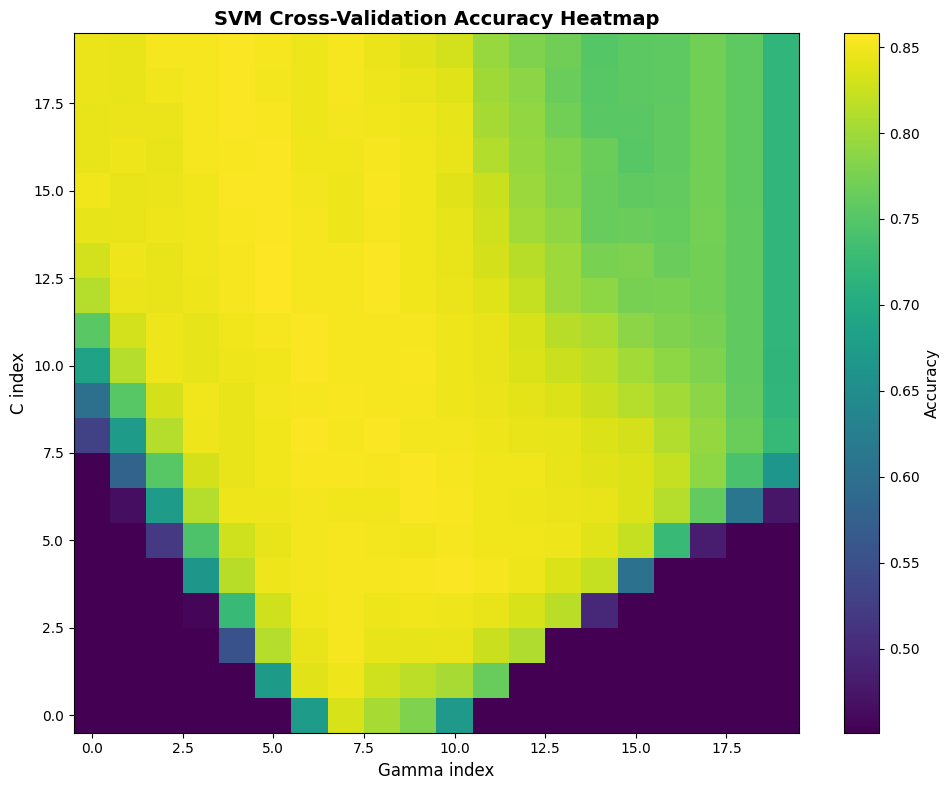

Max CV accuracy: 0.8580
Min CV accuracy: 0.4510


In [8]:
# @title 3.3 Visualize SVM Cross-Validation Results

# setup
gamma_vals = sorted(set(r['gamma'] for r in svm_results))
C_vals = sorted(set(r['C'] for r in svm_results))
svm_grid = np.array([[r['score'] for r in svm_results if r['C'] == C] for C in C_vals])

# heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(svm_grid, aspect='auto', cmap='viridis', origin='lower')
ax.set_xlabel('Gamma index', fontsize=12)
ax.set_ylabel('C index', fontsize=12)
ax.set_title('SVM Cross-Validation Accuracy Heatmap', fontsize=14, fontweight='bold')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Accuracy', fontsize=11)
plt.tight_layout()
plt.show()

# print upper & lower bound
print(f"Max CV accuracy: {svm_grid.max():.4f}")
print(f"Min CV accuracy: {svm_grid.min():.4f}")


In [9]:
# @title 3.4 Train Final SVM Model

# train
svm_model = SVC(
    kernel='rbf',
    gamma=svm_best_params['gamma'],
    C=svm_best_params['C'],
    random_state=42
)
svm_model.fit(X_train, y_train)

SVC(C=np.float64(26.366508987303583), gamma=np.float64(0.02069138081114789),
    random_state=42)

In [10]:
# @title 3.5 Analyze Final SVM Model

# test
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_error = 1 - svm_accuracy

# print results
print("\nSVM Results:")
print(f"  Optimal gamma: {svm_best_params['gamma']:.4f}")
print(f"  Optimal C: {svm_best_params['C']:.4f}")
print(f"  Test Error: {svm_error:.4f} ({svm_error*100:.2f}%)")
print(f"  Test Accuracy: {svm_accuracy:.4f} ({svm_accuracy*100:.2f}%)")


SVM Results:
  Optimal gamma: 0.0207
  Optimal C: 26.3665
  Test Error: 0.1661 (16.61%)
  Test Accuracy: 0.8339 (83.39%)


## 4. MLP

### Description:

This section implements an MLP classifier with a single hidden layer using tanh activation. K-fold cross-validation determines the optimal number of hidden neurons. The best model is trained on the full training set and evaluated on test data.

### Table of Contents:
- 4.1 MLP Cross-Validation Function
- 4.2 Perform MLP Cross-Validation
- 4.3 Visualize MLP Cross-Validation Results
- 4.4 Train Final MLP Model
- 4.5 Analyze Final MLP Model

In [11]:
# @title 4.1 MLP Cross-Validation Function
def mlp_cross_validation(
    X_train: np.ndarray,
    y_train: np.ndarray,
    k_folds: int = 10
  ) -> Tuple[Dict[str, int], List[Dict[str, float]]]:
  """
  Perform K-fold cross-validation for MLP hyperparameter selection.
  """
  # hyperparameter space
  hidden_neurons = [5, 10, 15, 20, 25, 30, 40, 50, 75, 100]

  # initialize
  kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
  best_score = 0.0
  best_params: Dict[str, int] = {}
  results: List[Dict[str, float]] = []

  print("MLP Cross-Validation Progress:")
  for n_neurons in hidden_neurons:
    scores = []
    for train_idx, val_idx in kf.split(X_train):
      X_tr, X_val = X_train[train_idx], X_train[val_idx]
      y_tr, y_val = y_train[train_idx], y_train[val_idx]

      # train & evaluate mlp with current parameters
      model = MLPClassifier(
          hidden_layer_sizes=(n_neurons,),
          activation='tanh',
          solver='adam',
          max_iter=1000,
          random_state=42
      )
      model.fit(X_tr, y_tr)
      score = accuracy_score(y_val, model.predict(X_val))
      scores.append(score)

    # compute average score
    avg_score = np.mean(scores)
    results.append({'n_neurons': n_neurons, 'score': avg_score})

    # update best parameters
    if avg_score > best_score:
      best_score = avg_score
      best_params = {'n_neurons': n_neurons}

    # logging
    print(f"  {n_neurons} neurons: {avg_score:.4f}")

  # final results
  print(f"\nBest MLP params: {best_params['n_neurons']} neurons")
  print(f"Best CV accuracy: {best_score:.4f}")

  return best_params, results

In [12]:
# @title 4.2 Perform MLP Cross-Validation
mlp_best_params, mlp_results = mlp_cross_validation(X_train, y_train, k_folds=10)

MLP Cross-Validation Progress:
  5 neurons: 0.8420
  10 neurons: 0.8480
  15 neurons: 0.8500
  20 neurons: 0.8540
  25 neurons: 0.8510
  30 neurons: 0.8520
  40 neurons: 0.8520
  50 neurons: 0.8540
  75 neurons: 0.8580
  100 neurons: 0.8550

Best MLP params: 75 neurons
Best CV accuracy: 0.8580


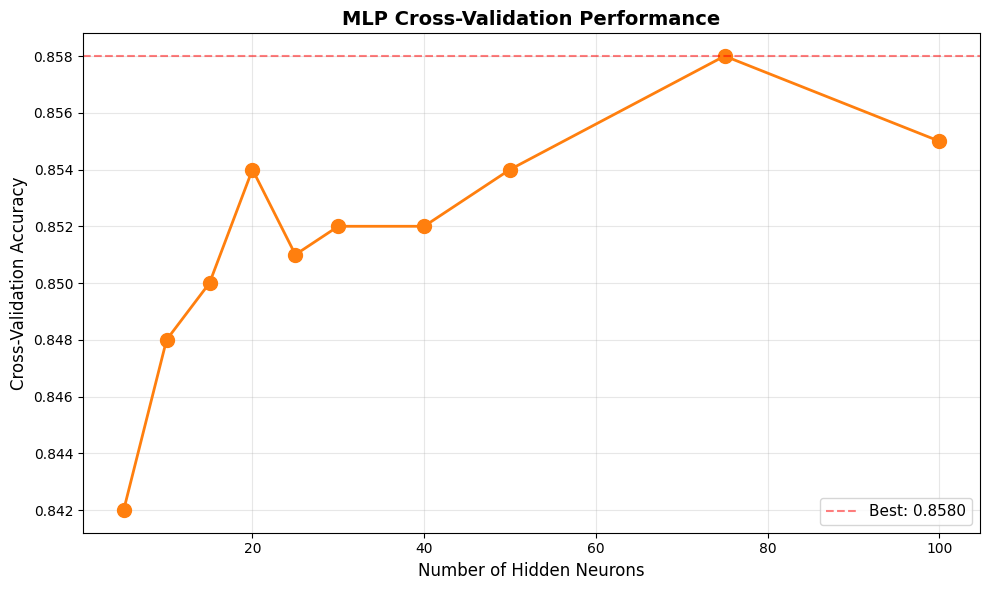

In [13]:
# @title 4.3 Visualize MLP Cross-Validation Results

# setup
neurons = [r['n_neurons'] for r in mlp_results]
scores = [r['score'] for r in mlp_results]

# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(neurons, scores, 'o-', linewidth=2, markersize=10, color='#ff7f0e')
ax.set_xlabel('Number of Hidden Neurons', fontsize=12)
ax.set_ylabel('Cross-Validation Accuracy', fontsize=12)
ax.set_title('MLP Cross-Validation Performance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=max(scores), color='r', linestyle='--', alpha=0.5, label=f'Best: {max(scores):.4f}')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [14]:
# @title 4.4 Train Final MLP Model

# train
mlp_model = MLPClassifier(
    hidden_layer_sizes=(mlp_best_params['n_neurons'],),
    activation='tanh',
    solver='adam',
    max_iter=1000,
    random_state=42
)
mlp_model.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(75,), max_iter=1000,
              random_state=42)

In [15]:
# @title 4.4 Analzye Final MLP Model

# test
mlp_pred = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_pred)
mlp_error = 1 - mlp_accuracy

# print results
print("MLP Results:")
print(f"  Optimal hidden neurons: {mlp_best_params['n_neurons']}")
print(f"  Activation function: tanh")
print(f"  Test Error: {mlp_error:.4f} ({mlp_error*100:.2f}%)")
print(f"  Test Accuracy: {mlp_accuracy:.4f} ({mlp_accuracy*100:.2f}%)")

MLP Results:
  Optimal hidden neurons: 75
  Activation function: tanh
  Test Error: 0.1684 (16.84%)
  Test Accuracy: 0.8316 (83.16%)


## 5. Analysis & Comparison

### Description:

This section visualizes the decision boundaries learned by both SVM and MLP classifiers on the test data. A side-by-side comparison reveals how each model handles the overlapping concentric disk structure and where classification errors occur.

### Table of Contents:
- 5.1 Plot Decision Boundary Function
- 5.2 SVM vs. MLP Comparison

In [16]:
# @title 5.1 Plot Deciscion Boundary Function
def plot_decision_boundary(
    X: np.ndarray,
    y: np.ndarray,
    model: object,
    title: str,
    ax: Optional[Axes] = None
  ) -> Axes:
  """
  Plot data points and decision boundary for a trained classifier.
  """
  if ax is None:
    fig, ax = plt.subplots(figsize=(8, 8))

  # create mesh
  h = 0.02
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))

  # predict on mesh
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  # plot decision boundary
  ax.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2, linestyles='solid')

  # get predictions for all points
  y_pred = model.predict(X)
  correct_minus = (y == -1) & (y_pred == -1)
  incorrect_minus = (y == -1) & (y_pred == 1)
  correct_plus = (y == 1) & (y_pred == 1)
  incorrect_plus = (y == 1) & (y_pred == -1)

  # count predictions
  n_correct_minus = np.sum(correct_minus)
  n_incorrect_minus = np.sum(incorrect_minus)
  n_correct_plus = np.sum(correct_plus)
  n_incorrect_plus = np.sum(incorrect_plus)
  n_total = len(y)
  n_correct_total = n_correct_minus + n_correct_plus
  n_incorrect_total = n_incorrect_minus + n_incorrect_plus

  # plot correctly classified
  if np.any(correct_minus):
    ax.scatter(X[correct_minus, 0], X[correct_minus, 1], c='blue', label=f'Class -1 Correct ({n_correct_minus})', alpha=0.6, edgecolors='k', s=30)

  if np.any(correct_plus):
    ax.scatter(X[correct_plus, 0], X[correct_plus, 1], c='red', label=f'Class +1 Correct ({n_correct_plus})', alpha=0.6, edgecolors='k', s=30)

  # plot misclassified
  if np.any(incorrect_minus):
    ax.scatter(X[incorrect_minus, 0], X[incorrect_minus, 1], c='lime', label=f'Class -1 Incorrect ({n_incorrect_minus})', alpha=0.9, edgecolors='darkgreen', s=60, marker='X')

  if np.any(incorrect_plus):
    ax.scatter(X[incorrect_plus, 0], X[incorrect_plus, 1], c='magenta', label=f'Class +1 Incorrect ({n_incorrect_plus})', alpha=0.9, edgecolors='darkviolet', s=60, marker='X')

  ax.set_xlabel('x1', fontsize=11)
  ax.set_ylabel('x2', fontsize=11)
  ax.set_title(title, fontsize=12, fontweight='bold')
  ax.legend(fontsize=9, loc='best')
  ax.grid(True, alpha=0.3)
  ax.axis('equal')

  # print statistics
  print(f"\n{title}")
  print(f"  Total samples: {n_total}")
  print(f"  Correctly classified: {n_correct_total} ({n_correct_total/n_total*100:.2f}%)")
  print(f"    - Class -1 correct: {n_correct_minus}")
  print(f"    - Class +1 correct: {n_correct_plus}")
  print(f"  Misclassified: {n_incorrect_total} ({n_incorrect_total/n_total*100:.2f}%)")
  print(f"    - Class -1 misclassified: {n_incorrect_minus}")
  print(f"    - Class +1 misclassified: {n_incorrect_plus}")

  return ax


SVM Test Results
Error: 0.1661 (16.61%)
  Total samples: 10000
  Correctly classified: 8339 (83.39%)
    - Class -1 correct: 4176
    - Class +1 correct: 4163
  Misclassified: 1661 (16.61%)
    - Class -1 misclassified: 824
    - Class +1 misclassified: 837

MLP Test Results
Error: 0.1684 (16.84%)
  Total samples: 10000
  Correctly classified: 8316 (83.16%)
    - Class -1 correct: 4041
    - Class +1 correct: 4275
  Misclassified: 1684 (16.84%)
    - Class -1 misclassified: 959
    - Class +1 misclassified: 725


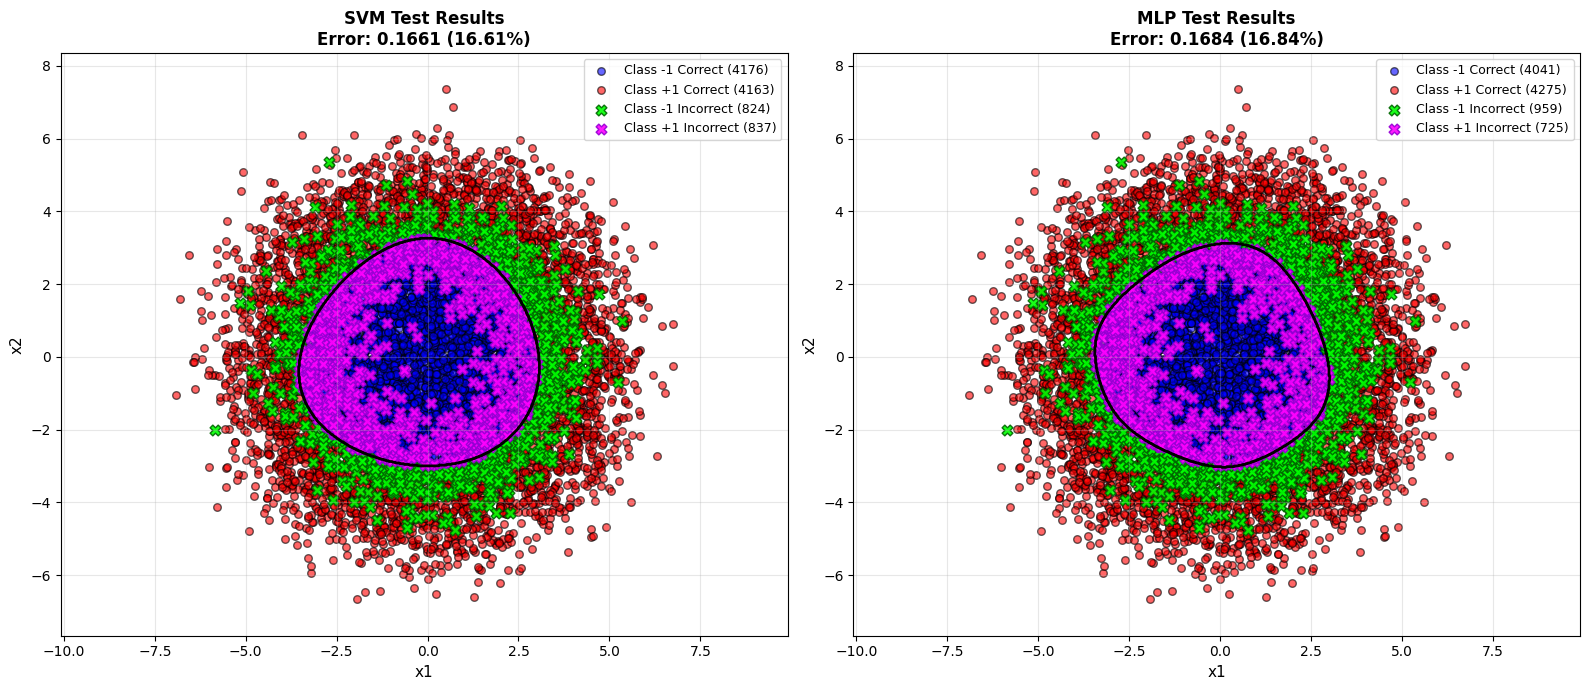

In [17]:
# @title 5.2 SVM vs. MLP Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

plot_decision_boundary(X_test, y_test, svm_model, f'SVM Test Results\nError: {svm_error:.4f} ({svm_error*100:.2f}%)', axes[0])
plot_decision_boundary(X_test, y_test, mlp_model, f'MLP Test Results\nError: {mlp_error:.4f} ({mlp_error*100:.2f}%)', axes[1])

plt.tight_layout()
plt.show()